# Gaussian process regression

## Vittorio Orlandi, Graham Tierney, Alessandro Zito

This file runs a simulation to compare the time performance of 3 different packages for Bayesian Gaussian process regression:

1) Hard coded Gibbs sampler is full python (no Cpp)

2) PyStan (with script similar to the one depicted 
[here](https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html) 

3) GPy [here](https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb)

4) FIFA_GP with HODLR approximation (out own implementation). See this [paper](https://arxiv.org/pdf/2006.06537.pdf) for references 

The purpose of this comparison is to test the power of our implementation when using standard tools for Gaussian Process regression.

In [ ]:
# To install the package
!pip install --index-url https://test.pypi.org/simple/ fifa-gp

In [21]:
import pystan  # Version used: 2.19.1.1. 
import numpy as np 
import scipy
import GPy
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from timeit import timeit
import time
from fifa_gp.regression import FIFA_GP

We generate the datasets as follows:
$$x \sim N_{[-2,2]}(0,1)$$
and 
$$y = f(x) + \epsilon$$
with $$f(x) = \sin(2x) + \frac18e^{x} \qquad \epsilon \sim N(0, 1/\tau)$$
and $\tau = 1$.

In [2]:
## Useful functions

def f(x):
    """Function to compute the mean process f"""
    return np.sin(2*x) + np.exp(x)/8

def simulate_data(n, a, b, tau, scale = 1):
    """Simulate the data"""
    x = truncnorm(a/scale,b/scale, scale = scale).rvs(n)
    y = f(x) + np.random.normal(0,np.sqrt(1/tau), size = n)
    return np.c_[y, x]

def timer(f):    # time is defined with any f
    """Times how long f takes."""
    
    def g(*args, **kwargs):    # *args, **kwargs. Any arguents are good!!
        start = time.time()     
        res = f(*args, **kwargs)  # do your f function here
        elapsed = time.time() - start
        return res, elapsed # res is the output of your function
    return g

In [4]:
# Generate the datasets for the simulation
np.random.seed(191)
n_list = [100, 250, 500, 750, 1000, 2000]
a, b = -2, 2 
tau = 1

simualtion_data = {str(n_list[i]): simulate_data(n_list[i], a, b, tau) for i in range(len(n_list))}

In [5]:
y = simualtion_data["500"][:, 0]
x = simualtion_data["500"][:, 1]

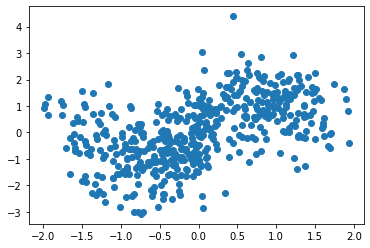

In [6]:
## Just to plot
plt.scatter(x,y)
pass

## 1) Hard-coded Gibbs sampler


In [ ]:
def Gibbs_build_K(sigma2f, rho, D):
    """This function builds the Kernel for a given vector of observations."""
    n = D.shape[0]
    return sigma2f * np.exp(-rho*D) + np.eye(n) * 1e-8

def Gibbs_get_Kinvs(sigma2f, rho, D):
    """Compute K, Kinv and K tau"""
    n = D.shape[0]
    K = Gibbs_build_K(sigma2f, rho, D) 
    K_inv =  scipy.linalg.inv(K)
    K_Ktau_inv = K @ np.linalg.inv(K + np.eye(n)/tau)
    return K, K_inv, K_Ktau_inv

def Gibbs_Proposalmatrix(rho_list):
    """Proposal probabilities"""
    nrhos = rho_list.shape[0]
    rho_ind = np.arange(nrhos)
    a = np.exp(-scipy.spatial.distance_matrix(rho_ind[:,None], rho_ind[:,None])**2)
    probMatrix = (a/a.sum(axis = 0)[:, None])
    return probMatrix

def Gibbs_sample_tau(y, f, a1, b1):
    """Sample from the full conditional of tau"""
    n = y.shape[0]
    tau_rate = 0.5*(b1 + np.sum((y-f)**2))
    tau = np.random.gamma(size = 1, shape = 0.5*(a1 + n), scale = 1/tau_rate)
    return tau

def Gibbs_sample_sigma2f(f, sigma2f_current, K_inv, a2, b2):
    """Sample from the full conditional of sigma2f"""
    n = f.shape[0]
    sigma2f_rate = 0.5*(b2 + sigma2f_current*f.T @ K_inv @ f)
    sigma2f_inv = np.random.gamma(size = 1, shape = 0.5*(a2 + n), scale = 1/sigma2f_rate)
    sigma2f = 1/sigma2f_inv
    return sigma2f
        
def Gibbs_sampleRho_MH(rho_list, D, current_ind, probMatrix, sigma2f, f):
    """ Sample one rho via MH"""
    # Sample the new index
    probs = probMatrix[current_ind]
    
    new_ind = np.random.choice(np.arange(probMatrix.shape[0]), size = 1, p = probs)[0]
    if new_ind == current_ind:
        return current_ind
    
    else:
        K_new = Gibbs_build_K(sigma2f, rho_list[new_ind], D)
        K_inv_new = scipy.linalg.inv(K_new)
        K_det_new = scipy.linalg.det(K_new) + 1e-8
        
        K_old = Gibbs_build_K(sigma2f, rho_list[current_ind], D)
        K_inv_old = scipy.linalg.inv(K_old)
        K_det_old = scipy.linalg.det(K_old) + 1e-8
        
        # Compute the MH log ratio
        lQoldToNew = np.log(probs[new_ind])
        lQnewToOld = np.log(probMatrix[new_ind, current_ind])

        quad_tmp_old =  f.T @ K_inv_old @ f
        quad_tmp_new =  f.T @ K_inv_new @ f
        llold = -0.5 * (np.log(K_det_old) + quad_tmp_old)
        llnew = -0.5 * (np.log(K_det_new) + quad_tmp_new)
        
        # Acceptance probability
        lA = llnew + lQnewToOld - llold - lQoldToNew
        
        if np.random.rand() < np.exp(lA): 
            return new_ind
        else:
            return current_ind
def Gibbs_samplef(y, K_Ktau_inv, tau):
    """Sample f"""
    return np.random.multivariate_normal(mean = K_Ktau_inv @ y, cov = tau * K_Ktau_inv, size=1)[0]

def Gibbs_GP(X, y, n_iter, startvals, burnin = 0):
    """Gaussian process Gibbs sampler."""
    
    # Step 00 - Create empy vectors to store the quantities
    n =  X.shape[0]
    f_vals = np.zeros((n_iter, n))
    pars = np.zeros((n_iter, 3))
    
    # Step 0 - initialize the quantities
    rho_ind = startvals["rho_ind"]
    rho_list = startvals["rho_list"]
    rho = rho_list[rho_ind]
    tau = startvals["tau"]
    sigma2f = startvals["sigma2f"]
    a1, b1  =  startvals["tau_hyper"]
    a2, b2  =  startvals["sigma2f_hyper"]
    D = scipy.spatial.distance_matrix(X[:, None],X[:, None])**2
    probMatrix = Gibbs_Proposalmatrix(rho_list)
    
    # Run the Sampler
    for i in range(n_iter + burnin):
        
        ## Step 1 - Build K and sample f
        K, K_inv, K_Ktau_inv =  Gibbs_get_Kinvs(sigma2f, rho, D)
        f = Gibbs_samplef(y, K_Ktau_inv, tau)
       
        ## Step 2 - Sample tau
        tau = Gibbs_sample_tau(y, f, a1, b1)
        
        # Step 3 - Sample sigma2f
        sigma2f = Gibbs_sample_sigma2f(f, sigma2f, K_inv, a2, b2)
        
        # Step 4 - Sample rho with a Metropolis step
        rho_ind = Gibbs_sampleRho_MH(rho_list, D, current_ind = rho_ind, probMatrix = probMatrix, sigma2f=sigma2f, f=f)
        rho =  rho_list[rho_ind]
        
        # Save the quantities
        f_vals[i] = f.ravel()
        pars[i, 0] = tau
        pars[i, 1] = rho
        pars[i, 2] = sigma2f
    
    return f_vals, pars

@timer
def test_GibbsSampler(simualtion_data, n, n_iter):
    """Test the Gibbs sampler"""
    # Hardcode the starting values
    startvals = {"rho_ind":0, 
             "rho_list": np.linspace(0.5, 2.5, 50), 
             "tau" : 1,
             "sigma2f" : 1,
             "tau_hyper" : (1,1),
             "sigma2f_hyper" :(1,1)}
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    f_vals, post_pars = Gibbs_GP(x, y, n_iter, startvals)
    return f_vals, post_pars

In [ ]:
Gibbs_results = {}
Gibbs_times = np.zeros(len(n_list))
n_iter = 100
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    out = test_GibbsSampler(simualtion_data, n, n_iter)
    ## STORE THE VALUES
    Gibbs_results[str(n)] = out
    
    f_vals = out[0][0]
    samp = out[0][1]
    name_f = "output/Gibbs/Gibbs_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_vals)
    name_samp = "output/Gibbs/Gibbs_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    Gibbs_times[i] = out[1]

name_times = "output/Gibbs/Gibbs_times.npy"
np.save(name_times, Gibbs_times)

## 2) PySTAN 

In [ ]:
# Let's try to use stan
stanGP = """
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
  
    // Hyperparameters for the precision tau
  real<lower = 0> a1; 
  real<lower = 0> b1; 
  
  // Hyperparameters for the squared exp. kernel sigma2_f
  real<lower = 0> a2;
  real<lower = 0> b2;
  
}
transformed data {
  vector[N] mu = rep_vector(0, N);
}
parameters {
  real<lower=0> rho;
  real<lower=0> sigma2f;
  real<lower=0> tau;
}
model {
  matrix[N, N] L_K;
  matrix[N, N] K = cov_exp_quad(x, sigma2f, rho);
  real invtau = 1/tau;

  // diagonal elements
  for (n in 1:N)
    K[n, n] = K[n, n] + invtau;

  L_K = cholesky_decompose(K);

  rho ~ inv_gamma(5, 5);
  sigma2f ~ inv_gamma(a2/2, b2/2);
  tau ~ gamma(a1/2, b1/2);

  y ~ multi_normal_cholesky(mu, L_K);
}
"""

sm = pystan.StanModel(model_code=stanGP)

In [ ]:
@timer
def test_PyStan(stan_data, sm, n_iter):
    """Get the posterior via stan"""
    fit = sm.sampling(data=stan_data, iter=n_iter, chains=1)
    return fit

In [ ]:
stan_results = {}
n_iter = 100
stan_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    x = simualtion_data[str(n)][:, 1]
    y = simualtion_data[str(n)][:, 0]

    stan_data = {"N": n, 
                "x": list(x.ravel()),
                "y" : list(y.ravel()), 
                "a1": 1, "b1": 1,
                "a2": 1, "b2": 1}

    res = test_PyStan(stan_data, sm, n_iter = n_iter)
    
    stan_results[str(n)] = res
    
    samp = res[0].extract()
    samp = np.c_[samp["tau"], samp["rho"], samp["sigma2f"]]
    name_samp = "output/Pystan/Pystan_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    stan_times[i] = res[1]

name_times = "output/Pystan/stan_times.npy"
np.save(name_times, stan_times)

In [ ]:
# Sample from the posterior distribution give the stan samples
for n in n_list:
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    samp = np.load("output/Pystan/Pystan_sampler_postpars_" + str(n) + ".npy")
    f_stan = samplef_stan(x, y, samp)
    name_f = "output/Pystan/Pystan_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_stan)

## 3) GPy

In [ ]:
@timer
def test_GPy(x, y, n_iter, a1=1, b1=1, a2=1, b2=1):
    """Get the posterior via GPy"""
    m = GPy.models.GPRegression(x[:, None],y[:, None])
    
    # Set Kernel prior
    m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(5.,5))
    m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(a2/2.,b2/2))
    m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(a1/2,b1/2))
    
    # Fit the model
    hmc = GPy.inference.mcmc.HMC(m,stepsize=5e-2)
    s = hmc.sample(num_samples=n_iter)
    
    return m, hmc, s

def samplef_GPy(x, y, samp):
    """sample from the posterior of f from a stan output"""
    D = scipy.spatial.distance_matrix(x[:, None],x[:, None])**2
    n = x.shape[0]
    f_vals = np.zeros((samp.shape[0], n))
    for i in range(samp.shape[0]):
        sigma2f = samp[i, 0]
        rho = (1/2*samp[i, 1])
        tau = 1/samp[i, 2]
        K = Gibbs_build_K(sigma2f, rho, D)
        K_Ktau_inv = K @ np.linalg.inv(K + np.eye(n)/tau) 
        f = np.random.multivariate_normal(mean = K_Ktau_inv @ y, cov = tau * K_Ktau_inv, size=1)[0]
        f_vals[i] = f
    return f_vals

In [ ]:
GPy_results = {}
n_iter = 100
GPy_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    x = simualtion_data[str(n)][:, 1]
    y = simualtion_data[str(n)][:, 0]
    res = test_GPy(x, y, n_iter=n_iter)
    
    GPy_results[str(n)] = res

    samp = res[0][2]
    name_samp = "output/GPy/GPy_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    GPy_times[i] = res[1]

name_times = "output/GPy/GPy_times.npy"
np.save(name_times, GPy_times)

In [ ]:
for n in n_list:
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1] 
    samp = np.load("output/GPy/GPy_sampler_postpars_" + str(n) + ".npy")
    f_GPy = samplef_GPy(x, y, samp)
    name_f = "output/GPy/GPy_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_GPy)

## 4) FIFA GP

In [ ]:
@timer
def test_FIFAGP(n, n_iter):
    """Timer test fornthe FIFA GP """
    
    gp = FIFA_GP()()
    rho_choices = list(np.linspace(.5, 3, 50))
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    gp.fit(x[:, None],y[:, None],
           1,rho_choices,1,
           True,False,
           True,-1,
           1,1,1,1,
           1e-12,20,True,169,"none",
           0,n_iter,1,False)
    return gp

In [ ]:
FIFAGP_results = {}
n_iter = 100
FIFAGP_times = np.zeros(len(n_list))
for i in range(len(n_list)):
    print(i)
    n = n_list[i]
    out = test_FIFAGP(n, n_iter)
    
    ## STORE THE VALUES
    FIFAGP_results[str(n)] = out
    
    f_vals = out[0].f
    samp = out[0].get_params()
    name_f = "output/FIFAGP/FIFAGP_sampler_fout_" + str(n) +".npy"
    np.save(name_f, f_vals)
    name_samp = "output/FIFAGP/FIFAGP_sampler_postpars_" + str(n) +".npy"
    np.save(name_samp, samp)
    
    FIFAGP_times[i] = out[1]

name_times = "output/FIFAGP/FIFAGP_times.npy"
np.save(name_times, FIFAGP_times)

In [23]:
# Test FIFAGP for a larger dataset
n = 10000
df_large = simulate_data(n, a, b, tau)
y = df_large[:, 0]
x = df_large[:, 1]

@timer
def test_FIFAGP_big(x, y, n_iter):
    """Timer test fornthe FIFA GP """ 
    gp = FIFA_GP()
    rho_choices = list(np.linspace(.5, 3, 50))
    gp.fit(x[:, None],y[:, None],
           1,rho_choices,1,
           True,False,
           True,-1,
           1,1,1,1,
           1e-12,20,True,169,"none",
           0,n_iter,1,False)
    return gp

fifa_df_large = test_FIFAGP_big(x, y, n_iter = 100)


## Make plots

In [8]:
import seaborn as sns
import pandas as pd
sns.set_style("ticks")

In [9]:
df_times = pd.DataFrame({"FIFAGP": np.append(np.load("output/FIFAGP/FIFAGP_times.npy"), fifa_df_large[1]), 
       "Gibbs (Python)": np.append(np.load("output/Gibbs/Gibbs_times.npy"), np.nan),
       "GPy": np.append(np.load("output/GPy/GPy_times.npy"), np.nan), 
       "PyStan": np.append(np.load("output/Pystan/stan_times.npy"), np.nan), 
       "n": np.append(n_list, 10000)}).melt("n", value_name = "time (seconds)", var_name="method")
df_times["n"] = df_times["n"].astype("str")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


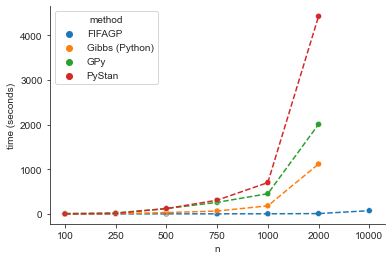

In [10]:
sns.scatterplot(data = df_times, x = "n", y = "time (seconds)", hue = "method")
sns.lineplot(data = df_times, x = "n", y = "time (seconds)", hue = "method",  linestyle='--', legend=False)
sns.despine()
plt.savefig('timeplot.png', dpi=300)
pass

In [11]:
def make_dataframe(n, simualtion_data):
    """Make a dataframe for later plotting"""
    y = simualtion_data[str(n)][:, 0]
    x = simualtion_data[str(n)][:, 1]
    df_samps = pd.DataFrame({"FIFAGP": np.load("output/FIFAGP/FIFAGP_sampler_fout_" + str(n) + ".npy").mean(axis = 1), 
           "Gibbs (Python)": np.load("output/Gibbs/Gibbs_sampler_fout_" + str(n) + ".npy").mean(axis = 0),
           "GPy": np.load("output/GPy/GPy_sampler_fout_" + str(n) + ".npy").mean(axis = 0), 
           "PyStan": np.load("output/Pystan/Pystan_sampler_fout_" + str(n) + ".npy").mean(axis = 0), 
           "x": x}).melt("x", value_name = "f", var_name="method")
    return x, y, df_samps


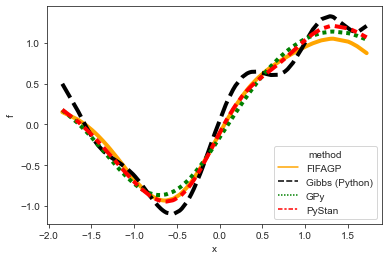

In [12]:
n = 100
x, y, df_samps = make_dataframe(n, simualtion_data)
plot_colors = ["orange", "black", "green", "red"]
lines, labels = sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors).get_legend_handles_labels()

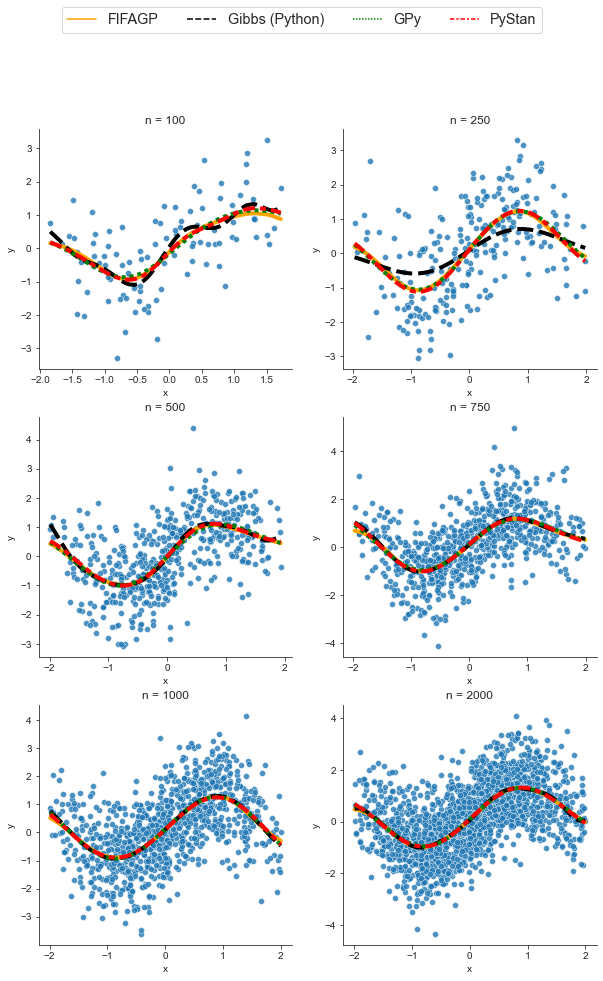

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))
plot_colors = ["orange", "black", "green", "red"]
############################ 100
n = 100
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[0,0])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[0,0],legend= False).set_title('n = 100')

############################ 250
n = 250
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[0,1])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[0,1],legend= False).set_title('n = 250')

############################ 500
n = 500
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[1,0])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[1,0], legend= False).set_title('n = 500')

############################ 750
n = 750
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[1,1])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[1,1], legend= False).set_title('n = 750')

############################ 1000
n = 1000
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[2,0])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[2,0],legend= False).set_title('n = 1000')

############################ 2000
n = 2000
x, y, df_samps = make_dataframe(n, simualtion_data)
sns.scatterplot(data = pd.DataFrame({"x":x, "y":y}), x = "x", y = "y", alpha = 0.8, ax = axs[2,1])
sns.lineplot(data = df_samps, x = "x", y = "f", hue = "method",  linewidth=4, style ="method", 
             palette = plot_colors, ax = axs[2,1], legend= False).set_title('n = 2000')

sns.despine()
plt.figlegend( lines, labels, loc = 'upper center', ncol=5, labelspacing=0., fontsize='x-large', title_fontsize='40' )

plt.savefig('model_performance.png', dpi=400)
pass

### Profiler for the Gibbs sampler

In [ ]:
n = 1000
startvals = {"rho_ind":0, 
         "rho_list": np.linspace(0.5, 2.5, 50), 
         "tau" : 1,
         "sigma2f" : 1,
         "tau_hyper" : (1,1),
         "sigma2f_hyper" :(1,1)}
y = simualtion_data[str(n)][:, 0]
x = simualtion_data[str(n)][:, 1]
n_iter = 100

In [ ]:
%prun -q -D Gibbs_profiler.prof Gibbs_GP(x, y, n_iter, startvals)

In [14]:
import pstats
p = pstats.Stats('Gibbs_profiler.prof')
p.strip_dirs()
p.sort_stats('cumulative')
p.print_stats("Gibbs_")
pass

Mon Apr 26 16:06:29 2021    Gibbs_profiler.prof

         21673 function calls (21173 primitive calls) in 128.777 seconds

   Ordered by: cumulative time
   List reduced from 102 to 8 due to restriction <'Gibbs_'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.507    0.507  128.767  128.767 <ipython-input-12-f0379a032f44>:75(Gibbs_GP)
      100    0.446    0.004   89.922    0.899 <ipython-input-12-f0379a032f44>:71(Gibbs_samplef)
      100    4.863    0.049   25.812    0.258 <ipython-input-12-f0379a032f44>:6(Gibbs_get_Kinvs)
      100    0.061    0.001   12.416    0.124 <ipython-input-12-f0379a032f44>:37(Gibbs_sampleRho_MH)
      184    4.553    0.025    4.901    0.027 <ipython-input-12-f0379a032f44>:1(Gibbs_build_K)
      100    0.067    0.001    0.071    0.001 <ipython-input-12-f0379a032f44>:29(Gibbs_sample_sigma2f)
      100    0.005    0.000    0.014    0.000 <ipython-input-12-f0379a032f44>:22(Gibbs_sample_tau)
        1    0.000    0.000    